# **Import Dataset**

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uhjoV3WNT5LUQzPsvxmG")
project = rf.workspace("test-kqntz").project("marul-mucm2")
version = project.version(2)
dataset = version.download("yolov5")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to marul-2 in yolov5pytorch:: 100%|██████████| 876/876 [00:00<00:00, 3733.92it/s]


# **Import Necessary Libraries**

In [2]:
# Install necessary libraries
!pip install roboflow scikit-image opencv-python-headless

# Import necessary libraries
from roboflow import Roboflow
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import cv2
import numpy as np
import os
import glob

# **Functions and Parameters**

In [12]:
hog_params = {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'block_norm': 'L2'}
window_size = (64, 64)  # HOG window size
positive_label = 'Lettuce'  # Label for lettuce in the dataset

def load_annotations(annotations_path, img_path):
    bboxes = []
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(annotations_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            values = line.strip().split()

            # Ensure we have at least 5 values
            if len(values) < 5:
                print(f"Skipping malformed annotation line in {annotations_path}: {line}")
                continue

            # Only use the first five values
            class_id, x_center, y_center, width, height = map(float, values[:5])
            x_center, y_center, width, height = x_center * w, y_center * h, width * w, height * h
            x1, y1 = int(x_center - width / 2), int(y_center - height / 2)
            x2, y2 = int(x_center + width / 2), int(y_center + height / 2)
            bboxes.append((x1, y1, x2, y2))

    return img, bboxes


# Function to extract HOG features
def get_hog_features(image, hog_params):
    # Convert to grayscale if the image has multiple channels
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(cv2.resize(image, window_size), **hog_params).reshape(1, -1)


# **Data-Preprocessing for HOG**

In [35]:
def prepare_data(dataset_path):
    X, y = [], []

    # Paths to image and label directories
    image_dir = os.path.join(dataset_path, 'train', 'images')
    label_dir = os.path.join(dataset_path, 'train', 'labels')

    for img_path in glob.glob(os.path.join(image_dir, '*.jpg')):
        annotation_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')

        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        # Check if annotation file exists
        if not os.path.exists(annotation_path):
            print(f"Annotation not found for {img_path}")
            continue

        img, bboxes = load_annotations(annotation_path, img_path)
        h, w = img.shape[:2]

        # Process each bounding box
        for bbox in bboxes:
            x1 = max(0, min(w - 1, bbox[0]))
            y1 = max(0, min(h - 1, bbox[1]))
            x2 = max(0, min(w - 1, bbox[2]))
            y2 = max(0, min(h - 1, bbox[3]))

            if x2 <= x1 or y2 <= y1:
                print(f"Invalid bbox after clamping for {img_path} at bbox {bbox}")
                continue

            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                print(f"Empty crop for {img_path} at bbox {bbox}")
                continue

            hog_features = get_hog_features(crop, hog_params)
            X.append(hog_features)
            y.append(1)  # Label as 'Lettuce' class

    # Increase the number of negative samples per image to 10
    for img_path in glob.glob(os.path.join(image_dir, '*.jpg')):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        h, w = img.shape[:2]
        for _ in range(10):  # Generate 10 random crops per image
            x1, y1 = np.random.randint(0, w - window_size[0]), np.random.randint(0, h - window_size[1])
            crop = img[y1:y1 + window_size[1], x1:x1 + window_size[0]]

            if crop.size == 0:
                print(f"Empty random crop for {img_path} at position {(x1, y1)}")
                continue

            hog_features = get_hog_features(crop, hog_params)
            X.append(hog_features)
            y.append(0)  # Label as 'Not Lettuce'

    if not X:
        raise ValueError("No HOG features were extracted. Check dataset path and annotations.")

    return np.vstack(X), np.array(y)



X_train, y_train = prepare_data("/content/marul-2")

Invalid bbox after clamping for /content/marul-2/train/images/Image_17_jpg.rf.143cdd3289ff5714099aae7e591b495b.jpg at bbox (76, 0, 170, 0)
Invalid bbox after clamping for /content/marul-2/train/images/Image_17_jpg.rf.f002bc5735a7963dfd05d6f861b56536.jpg at bbox (76, 0, 171, 0)


# **Train**

In [36]:
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

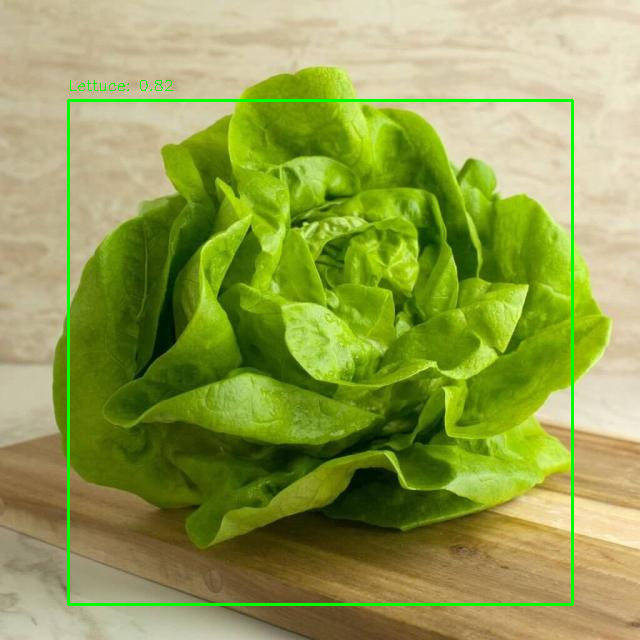

Processed image, findings: 1 objects, avg. conf: 0.82


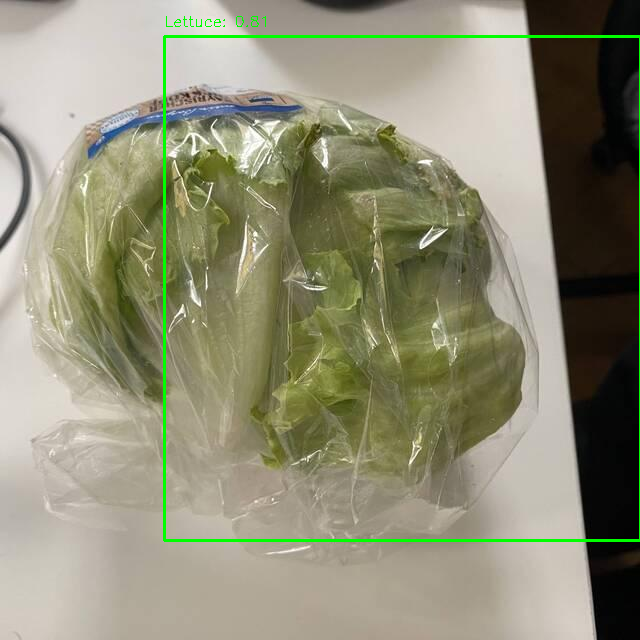

Processed image, findings: 1 objects, avg. conf: 0.81


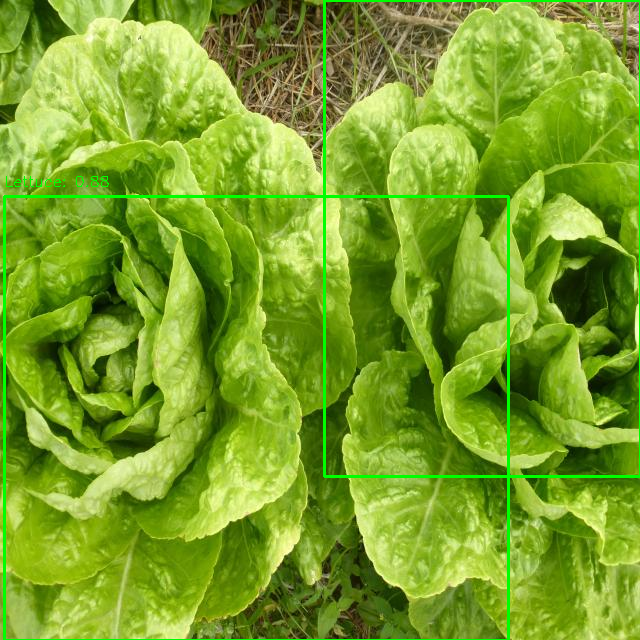

Processed image, findings: 2 objects, avg. conf: 0.89


In [ ]:
# Import cv2_imshow for displaying images in Google Colab
from google.colab.patches import cv2_imshow
import numpy as np

def non_maximum_suppression(boxes, overlap_thresh=0.7):
    if len(boxes) == 0:
        return []

    # Convert to numpy array
    boxes = np.array(boxes)
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    indices = np.argsort(y2)

    keep = []
    while len(indices) > 0:
        i = indices[-1]
        keep.append(i)
        suppress = [len(indices) - 1]

        for pos in range(len(indices) - 1):
            j = indices[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]

            if overlap > overlap_thresh:
                suppress.append(pos)

        indices = np.delete(indices, suppress)

    return boxes[keep].astype(int)

def test_on_image(img_path, model, confidence_threshold=0.8, box_padding=20):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    detections = []

    for y in range(0, h - window_size[1], 32):
        for x in range(0, w - window_size[0], 32):
            window = img[y:y + window_size[1], x:x + window_size[0]]
            if window.shape[:2] != (window_size[1], window_size[0]):
                continue

            hog_features = get_hog_features(window, hog_params)
            probabilities = model.predict_proba(hog_features)[0]
            confidence = probabilities[1]  # Confidence for the 'Lettuce' class
            if confidence >= confidence_threshold:
                x1 = max(0, x - box_padding)
                y1 = max(0, y - box_padding)
                x2 = min(w, x + window_size[0] + box_padding)
                y2 = min(h, y + window_size[1] + box_padding)
                detections.append((x1, y1, x2, y2, confidence))

    # Apply Non-Maximum Suppression
    filtered_detections = non_maximum_suppression([(x1, y1, x2, y2) for x1, y1, x2, y2, _ in detections])

    # Draw the filtered detections with labels
    for i, (x1, y1, x2, y2) in enumerate(filtered_detections):
        confidence = detections[i][4]  # Get the corresponding confidence level
        label = f"Lettuce: {confidence:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Display the image with the bounding boxes and labels
    cv2_imshow(img)

    # "Disguised" string-based summary
    num_detections = len(filtered_detections)
    avg_confidence = np.mean([det[4] for det in detections]) if detections else 0
    summary = f"Processed image, findings: {num_detections} objects, avg. conf: {avg_confidence:.2f}"
    print(summary)

# Example test on an image from the test set
test_on_image(os.path.join('/content/marul-2', 'test', 'images', 'Test1.jfif'), svm_clf)
test_on_image(os.path.join('/content/marul-2', 'test', 'images', 'Test2.jfif'), svm_clf)
test_on_image(os.path.join('/content/marul-2', 'test', 'images', 'Test3.jfif'), svm_clf)
